In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Question 1

Segments shape: (7100, 128)
Labels shape: (7100,)


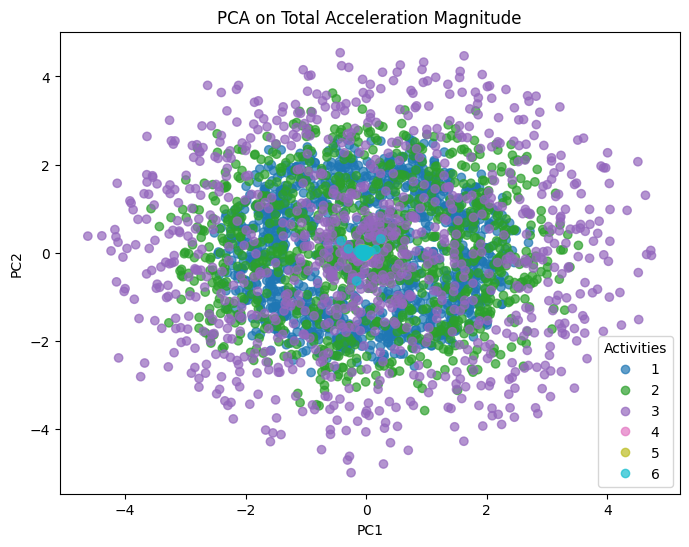

In [29]:
combined_path = "Combined"
train_path = os.path.join(combined_path, "Train")

# Activity → numeric mapping
activities = ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS",
              "SITTING","STANDING","LAYING"]
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,
           "SITTING":4,"STANDING":5,"LAYING":6}

# Step 1: Load all signals
all_segments = []
all_labels = []

window_size = 128
stride = 64

for activity in activities:
    folder_path = os.path.join(train_path, activity)
    files = sorted(os.listdir(folder_path))  # keep order consistent
    for f in files:
        file_path = os.path.join(folder_path, f)
        df = pd.read_csv(file_path, sep=",", header=0)

        # Extract columns
        ax = df.iloc[:, 0].values
        ay = df.iloc[:, 1].values
        az = df.iloc[:, 2].values
        acc_mag = np.sqrt(ax**2 + ay**2 + az**2)

        # Segment into windows
        for start in range(0, len(acc_mag) - window_size, stride):
            end = start + window_size
            segment = acc_mag[start:end]
            all_segments.append(segment)

            # Assign label based on folder name
            all_labels.append(classes[activity])

# Convert to arrays
segments = np.array(all_segments)   # shape: (n_windows, window_size)
labels = np.array(all_labels)

print("Segments shape:", segments.shape)
print("Labels shape:", labels.shape)

# Step 2: PCA
pca = PCA(n_components=2)
acc_pca = pca.fit_transform(segments)

# Step 3: Scatter plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(acc_pca[:,0], acc_pca[:,1], c=labels, cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Activities")
plt.title("PCA on Total Acceleration Magnitude")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Question 2

No, we can clearly see for the static activities the magnitude is always close to 0 so if on an avg the value of magnitude throughout a time interval is close to zero we say its a static activity else a dynamic activity.Hence, we dont need ML to classify them, this can be done by hard coding it.

Question 3

The raw accelerometer signals were first converted into total acceleration magnitude, which was then segmented into overlapping windows (128 samples with 50% overlap).Then, PCA was applied on these windowed segments to reduce them into two principal components.

In [30]:
acc_x = pd.read_csv(r"UCI HAR Dataset\UCI HAR Dataset\train\Inertial Signals\total_acc_x_train.txt",sep=r'\s+', header=None)
acc_y = pd.read_csv(r"UCI HAR Dataset\UCI HAR Dataset\train\Inertial Signals\total_acc_y_train.txt",sep=r'\s+', header=None)
acc_z = pd.read_csv(r"UCI HAR Dataset\UCI HAR Dataset\train\Inertial Signals\total_acc_z_train.txt",sep=r'\s+', header=None)

y_train = pd.read_csv(r"UCI HAR Dataset\UCI HAR Dataset\train\y_train.txt", header=None)  # activity labels


In [31]:
acc_mag = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)

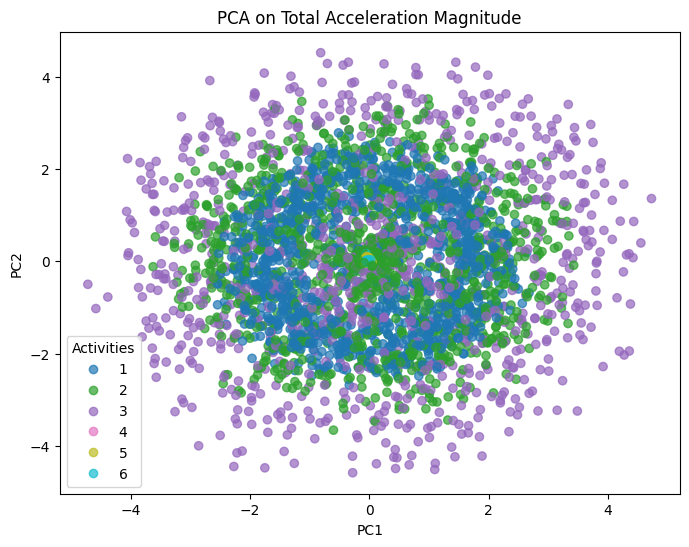

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
acc_pca = pca.fit_transform(acc_mag)

plt.figure(figsize=(8,6))
scatter = plt.scatter(acc_pca[:,0], acc_pca[:,1], c=y_train[0], cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Activities")
plt.title("PCA on Total Acceleration Magnitude")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Here we calculates total acceleration from the UCI HAR dataset, extracts key features using TSFEL, reduces them to 2 dimensions with PCA,

C:\Users\vansh\AppData\Local\Temp\ipykernel_27564\2278041039.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  acc_x = pd.read_csv(f"{base_path}/total_acc_x_train.txt", delim_whitespace=True, header=None)
C:\Users\vansh\AppData\Local\Temp\ipykernel_27564\2278041039.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  acc_y = pd.read_csv(f"{base_path}/total_acc_y_train.txt", delim_whitespace=True, header=None)
C:\Users\vansh\AppData\Local\Temp\ipykernel_27564\2278041039.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  acc_z = pd.read_csv(f"{base_path}/total_acc_z_train.txt", delim_whitespace=True, header=None)


Extracting features for total acceleration...
Final feature shape: (7352, 45)


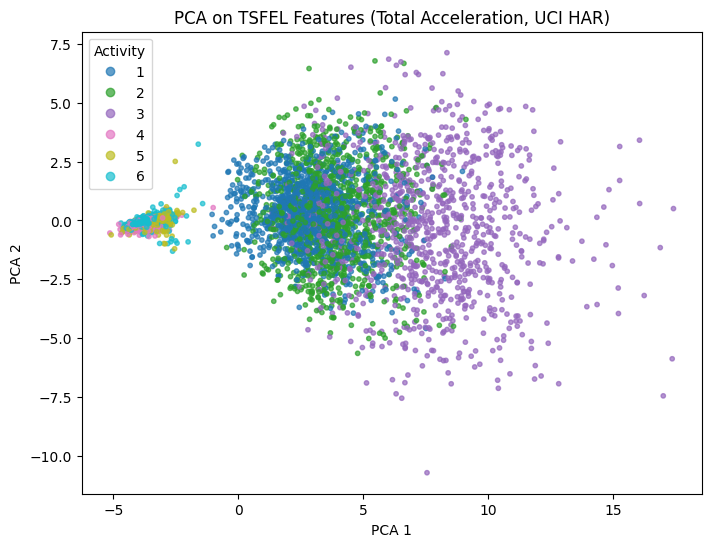

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tsfel
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # suppress TSFEL fs warning

# ------------------------
# 1. Load Data (x, y, z)
# ------------------------
base_path = r"UCI HAR Dataset\UCI HAR Dataset\train\Inertial Signals"
acc_x = pd.read_csv(f"{base_path}/total_acc_x_train.txt", delim_whitespace=True, header=None)
acc_y = pd.read_csv(f"{base_path}/total_acc_y_train.txt", delim_whitespace=True, header=None)
acc_z = pd.read_csv(f"{base_path}/total_acc_z_train.txt", delim_whitespace=True, header=None)

y_train = pd.read_csv(f"{base_path}/../y_train.txt", header=None).values.ravel()

# ------------------------
# 2. Compute total acceleration
# ------------------------
acc_total = acc_x**2 + acc_y**2 + acc_z**2

# ------------------------
# 3. TSFEL Config (statistical + temporal)
# ------------------------
cfg = tsfel.get_features_by_domain()
cfg_reduced = {k: v for k, v in cfg.items() if k in ["statistical", "temporal"]}

# ------------------------
# 4. Feature Extraction with sampling frequency
# ------------------------
def extract_features(df, fs=50):
    # fs = 50 Hz (adjust if your data has different sampling rate)
    features_list = []
    for i in range(len(df)):
        feats = tsfel.time_series_features_extractor(cfg_reduced, df.iloc[i, :], verbose=0, fs=fs)
        features_list.append(feats)
    return pd.concat(features_list, ignore_index=True)

print("Extracting features for total acceleration...")
features_total = extract_features(acc_total, fs=50)  # specify fs
print("Final feature shape:", features_total.shape)

# ------------------------
# 5. Normalize + PCA
# ------------------------
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_total)

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# ------------------------
# 6. Scatter plot
# ------------------------
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1],
                      c=y_train, cmap='tab10', alpha=0.7, s=10)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA on TSFEL Features (Total Acceleration, UCI HAR)")
plt.legend(*scatter.legend_elements(), title="Activity")
plt.show()


Here we are using the features given by the author and applying PCA on it to reduce the features to 2

C:\Users\vansh\AppData\Local\Temp\ipykernel_27564\1684686904.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(


Original features shape: (7352, 561)
PCA reduced shape: (7352, 2)


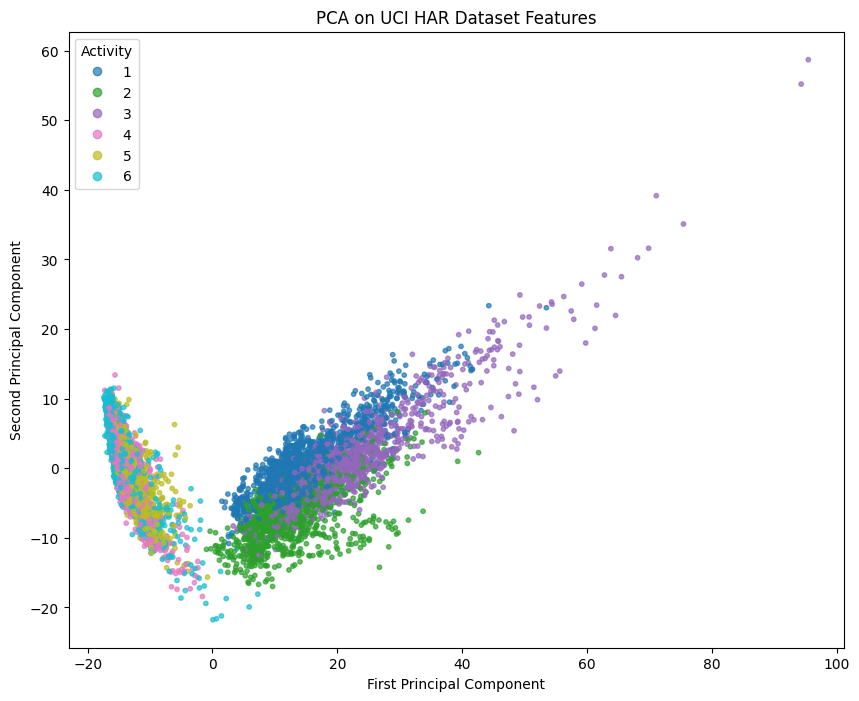

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Load dataset features + labels
X_train = pd.read_csv(
    r"UCI HAR Dataset\UCI HAR Dataset\train\X_train.txt",
    delim_whitespace=True, header=None
)

y_train = pd.read_csv(
    r"UCI HAR Dataset\UCI HAR Dataset\train\y_train.txt",
    header=None
).values.ravel()

print("Original features shape:", X_train.shape)  # (7352, 561)

# 2. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# 3. PCA (reduce to 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("PCA reduced shape:", X_pca.shape)

# 4. Scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=y_train, cmap="tab10", s=10, alpha=0.7)

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA on UCI HAR Dataset Features")
plt.legend(*scatter.legend_elements(), title="Activity")
plt.show()


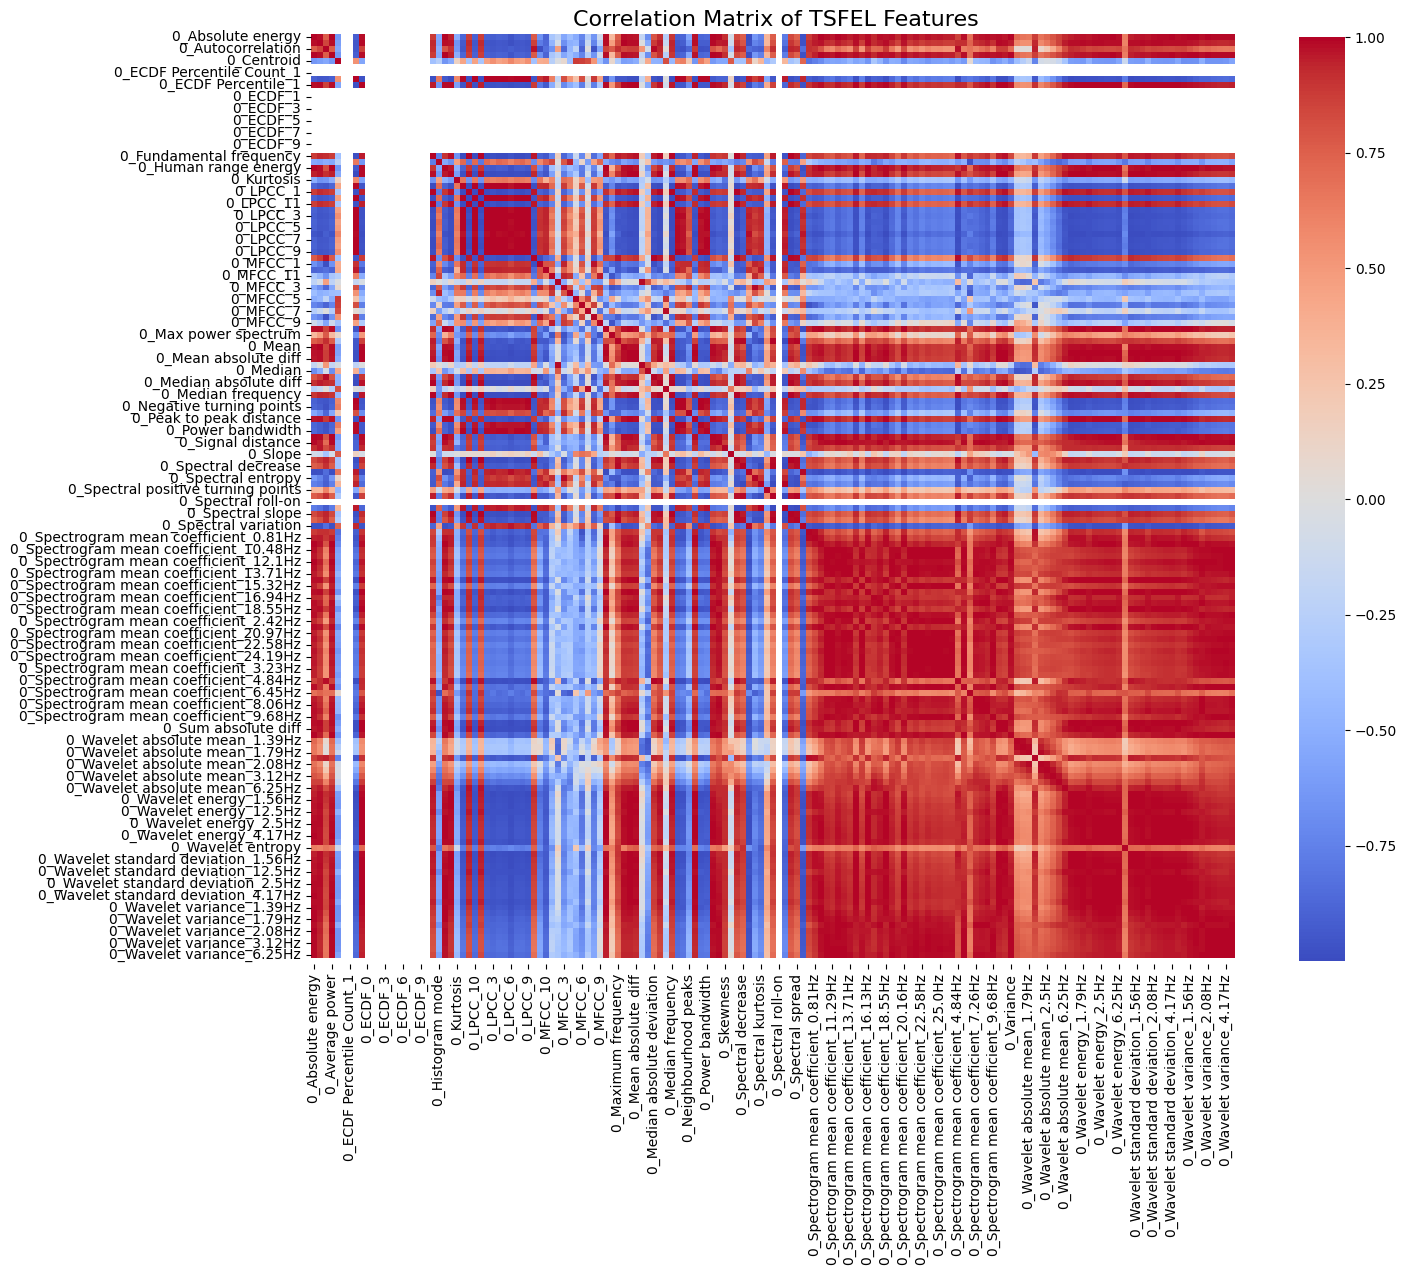

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tsfel
from sklearn.preprocessing import StandardScaler

time = 20
offset = 1000
folders = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]
classes = {"WALKING": 1, "WALKING_UPSTAIRS": 2, "WALKING_DOWNSTAIRS": 3,
           "SITTING": 4, "STANDING": 5, "LAYING": 6}
combined_dir = os.path.join("Combined")
dataset_dir = os.path.join(combined_dir, "Train")

X_train = []
y_train = [] 

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir, folder))
    file = files[5]

    df = pd.read_csv(os.path.join(dataset_dir, folder, file), sep=",", header=0)
    df = df[offset:offset + time * 50]

    X_train.append(df.values)
    y_train.append(classes[folder])

X_train = np.array(X_train)
y_train = np.array(y_train)

# ----- Extract TSFEL features -----
result = []

for datas in range(len(X_train)):
    lst = []
    for p in range(len(X_train[datas])):
        acc_total = (X_train[datas][p][0]**2 +
                     X_train[datas][p][1]**2 +
                     X_train[datas][p][2]**2)
        lst.append(acc_total)

    X_train_sig = pd.DataFrame(lst)
    cfg_file = tsfel.get_features_by_domain()
    X_feat = tsfel.time_series_features_extractor(cfg_file, X_train_sig, fs=50)
    result.append(X_feat)

df_combined = pd.concat(result, ignore_index=True)

scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df_combined),
                               columns=df_combined.columns)

# ----- Correlation Matrix -----
corr_matrix = df_standardized.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, cbar_kws={'shrink': 0.8}, square=True)
plt.title("Correlation Matrix of TSFEL Features", fontsize=16)
plt.show()


In [36]:
import numpy as np

# Threshold for considering high correlation
threshold = 0.9  

corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["Feature1", "Feature2", "Correlation"]

high_corr = corr_pairs[corr_pairs["Correlation"].abs() > threshold]

print("Highly correlated feature pairs:\n", high_corr)


Highly correlated feature pairs:
                        Feature1                   Feature2  Correlation
0             0_Absolute energy     0_Area under the curve     0.977961
2             0_Absolute energy            0_Average power     1.000000
4             0_Absolute energy        0_ECDF Percentile_0    -0.913632
5             0_Absolute energy        0_ECDF Percentile_1     0.979899
8             0_Absolute energy       0_Human range energy     0.995910
...                         ...                        ...          ...
9865   0_Wavelet variance_2.5Hz  0_Wavelet variance_4.17Hz     0.999261
9866   0_Wavelet variance_2.5Hz  0_Wavelet variance_6.25Hz     0.994597
9867  0_Wavelet variance_3.12Hz  0_Wavelet variance_4.17Hz     0.999757
9868  0_Wavelet variance_3.12Hz  0_Wavelet variance_6.25Hz     0.994221
9869  0_Wavelet variance_4.17Hz  0_Wavelet variance_6.25Hz     0.995586

[4238 rows x 3 columns]
